In [27]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import yaml
import yfinance as yf
import quantstats as qs

In [28]:
keys = yaml.safe_load(open('../keys.yaml', 'r'))

In [29]:
df = yf.download("BTC-USD", start="2010-01-01", end="2024-01-01")

# Display the data
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [30]:
fast_ma = vbt.MA.run(df['Close'], 37)
slow_ma = vbt.MA.run(df['Close'], 49)
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)
portfolio = vbt.Portfolio.from_signals(df['Close'], entries, exits, freq = 'd', direction = 'longonly')
portfolio.total_return()

46.53629688699568

In [31]:
portfolio.sharpe_ratio()

1.0442862084273556

In [32]:
returns = portfolio.daily_returns()
returns

Date
2014-09-17    0.000000
2014-09-18    0.000000
2014-09-19    0.000000
2014-09-20    0.000000
2014-09-21    0.000000
                ...   
2023-12-27    0.021694
2023-12-28   -0.018760
2023-12-29   -0.012397
2023-12-30    0.001366
2023-12-31    0.002569
Length: 3393, dtype: float64

In [33]:
returns.mean()

0.0015436572846669603

In [34]:
returns.mean()/returns.std()

0.05466043835218986

In [35]:
# sharpe ratio
mean_return = returns.mean()*365
volatility_return = returns.std()*np.sqrt(365)
(mean_return - 0.0)/volatility_return

1.0442862084273377

In [36]:
portfolio.sharpe_ratio(risk_free = 0.05)

-32.78078036561705

# sharpe ratio

In [37]:
np.sqrt(365)*(returns.mean()/returns.std()) # should be 252 as number of trading days, not calendar days, also - benchmark rate is missing

1.0442862084273377

In [38]:
np.sqrt(252)*(returns.mean()/returns.std())

0.8677075586020293

In [39]:
qs.stats.sharpe(returns)

0.8677075586020293

In [40]:
df_test = pd.DataFrame({'return1':returns, 'return2':returns*2})
qs.stats.sharpe(df_test)

return1    0.867708
return2    0.867708
dtype: float64

# calmar ratio

In [41]:
portfolio.calmar_ratio()

0.7899150293734258

In [42]:
qs.stats.calmar(returns)

0.509658124498354

In [43]:
help(qs.stats.calmar)

Help on function calmar in module quantstats.stats:

calmar(returns, prepare_returns=True)
    Calculates the calmar ratio (CAGR% / MaxDD%)



In [44]:


# Example daily returns data (replace with your actual data)
daily_returns = returns

# Calculate the geometric mean return
geometric_mean_return = np.prod(1 + daily_returns) ** (1 / len(daily_returns)) - 1

# Calculate the compound annual growth rate (CAGR)
beginning_value = 10000  # Initial investment value
ending_value = beginning_value * (1 + daily_returns).prod()  # Final investment value
investment_period_years = len(daily_returns) / 365  # 252
cagr = (ending_value / beginning_value) ** (1 / investment_period_years) - 1

# Calculate the maximum drawdown
cumulative_returns = (1 + daily_returns).cumprod()
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

# Calculate the annualized Calmar ratio using both methods
calmar_geometric = geometric_mean_return / abs(max_drawdown)
calmar_cagr = cagr / abs(max_drawdown)

print("Annualized Calmar Ratio (Using Geometric Mean Return):", calmar_geometric)
print("Annualized Calmar Ratio (Using CAGR):", calmar_cagr)


Annualized Calmar Ratio (Using Geometric Mean Return): 0.001746683173361901
Annualized Calmar Ratio (Using CAGR): 0.7899150293734258


# sortino ratio

In [45]:
portfolio.sortino_ratio()

1.5272044867665482

In [46]:
qs.stats.sortino(returns, annualize=True, periods = 365)

1.5272044867665513

In [47]:
help(qs.stats.sortino)

Help on function sortino in module quantstats.stats:

sortino(returns, rf=0, periods=252, annualize=True, smart=False)
    Calculates the sortino ratio of access returns
    
    If rf is non-zero, you must specify periods.
    In this case, rf is assumed to be expressed in yearly (annualized) terms
    
    Calculation is based on this paper by Red Rock Capital
    http://www.redrockcapital.com/Sortino__A__Sharper__Ratio_Red_Rock_Capital.pdf



In [48]:
returns

Date
2014-09-17    0.000000
2014-09-18    0.000000
2014-09-19    0.000000
2014-09-20    0.000000
2014-09-21    0.000000
                ...   
2023-12-27    0.021694
2023-12-28   -0.018760
2023-12-29   -0.012397
2023-12-30    0.001366
2023-12-31    0.002569
Length: 3393, dtype: float64

In [49]:
qs.stats.max_drawdown(returns)

-0.651935263412228

In [50]:
max_drawdown = qs.stats.max_drawdown(returns)

# Calculate drawdown duration
drawdowns = qs.stats.to_drawdown_series(returns)
drawdown_lengths = drawdowns[drawdowns == 0].groupby((drawdowns != 0).cumsum()).cumcount() + 1
max_drawdown_duration = drawdown_lengths.max()

print("Maximum Drawdown:", max_drawdown)
print("Maximum Drawdown Duration:", max_drawdown_duration)

Maximum Drawdown: -0.651935263412228
Maximum Drawdown Duration: 59


In [51]:
drawdowns

Date
2014-09-17    0.000000
2014-09-18    0.000000
2014-09-19    0.000000
2014-09-20    0.000000
2014-09-21    0.000000
                ...   
2023-12-27   -0.314245
2023-12-28   -0.327110
2023-12-29   -0.335452
2023-12-30   -0.334544
2023-12-31   -0.332835
Length: 3393, dtype: float64

In [53]:
drawdowns.min()

-0.651935263412228

<Axes: xlabel='Date'>

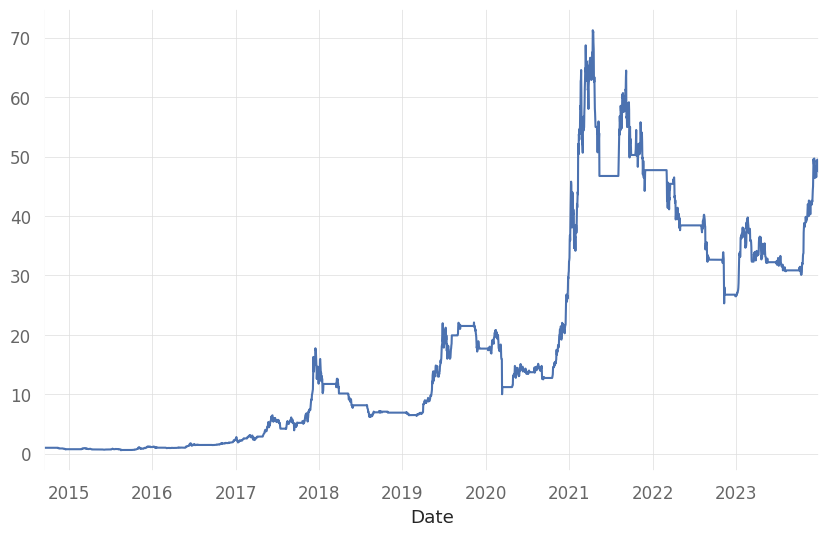

In [54]:
(returns + 1).cumprod().plot()

In [55]:
portfolio.max_drawdown()

-0.651935263412228

In [57]:
portfolio.stats()

Start                         2014-09-17 00:00:00
End                           2023-12-31 00:00:00
Period                         3393 days 00:00:00
Start Value                                 100.0
End Value                             4753.629689
Total Return [%]                      4653.629689
Benchmark Return [%]                  9141.645302
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        65.193526
Max Drawdown Duration           992 days 00:00:00
Total Trades                                   38
Total Closed Trades                            37
Total Open Trades                               1
Open Trade PnL                        1668.538436
Win Rate [%]                            40.540541
Best Trade [%]                         331.447576
Worst Trade [%]                        -36.826385
Avg Winning Trade [%]                   66.325423
Avg Losing Trade [%]                   -11.097991


<Axes: xlabel='Date'>

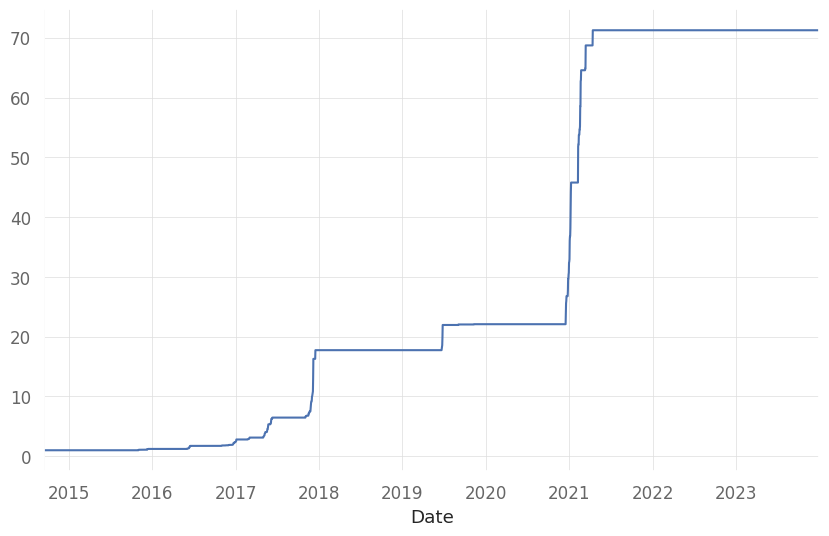

In [70]:
s = (returns + 1).cumprod()
df_mdd = s.to_frame()
df_mdd.columns = ['cumulative_returns']
df_mdd['cummax'] = df_mdd['cumulative_returns'].cummax()
df_mdd['cummax'].plot()

In [72]:
df_mdd.groupby('cummax')['cumulative_returns'].count().sort_values(ascending = False)

cummax
71.251152    993
17.740476    553
1.000000     412
22.083879    402
1.221332     171
            ... 
7.312317       1
2.421992       1
2.478822       1
2.532414       1
1.090732       1
Name: cumulative_returns, Length: 125, dtype: int64

In [77]:
df_mdd['cummax'].value_counts().head(1).iloc[0]

993